# **Mushroom Classification - Playground Series**

The objectives of this notebooks are:

- Use a preprocess dataset from previous exploration and implement other preprocessing steps for categorical vairables.
- Benchmark models using crossvalidation using ml3 package.
- Ensemble predictions of experiments.

Since I am new to ml3 this challenge is a great way to learn mlr3 potential.

<span style="color:crimson; font-size: 20px;">**Feedback is always welcome, this is my first Kaggle notebook!**</span>

# **Set-Up**

In [3]:
# Function to install packages if not already installed
install_if_missing <- function(packages) {
  new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
  if(length(new_packages)) {
    install.packages(new_packages, dependencies = TRUE)
  }
}

# List of required packages
required_packages <- c(
  "mlr3",
  "mlr3learners",
  "mlr3pipelines",
  "mlr3tuning",
  "data.table",
  "future",
  "progressr",
  "mlr3viz",
  "lightgbm",
  "mlr3extralearners"
)

# Install missing packages
install_if_missing(required_packages)

# Installing
# remotes::install_github("mlr-org/mlr3extralearners@*release") # For lightgbm

# Load the packages
lapply(required_packages, library, character.only = TRUE)

# Print confirmation
cat("All required packages have been installed and loaded.\n")


[[1]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[2]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[3]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[4]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[5]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[6]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[7]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[8]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[9]]
 [1] "lightgbm"      "mlr3viz"       "progressr"     "future"       
 [5] "data.table"    "mlr3tuning"    "paradox"       "mlr3pipelines"
 [9] "mlr3learners"  "mlr3"          "stats"         "graphics"     
[13] "grDevices"     "utils"         "datasets"      "methods"      
[17] "base"         

[[10]]
 [1] "mlr3extralearners" "lightgbm"          "mlr3viz"          
 [4] "progressr"         "future"            "data.table"       
 [7] "mlr3tuning"        "paradox"           "mlr3pipelines"    
[10] "mlr3learners"      "mlr3"              "stats"            
[13] "graphics"          "grDevices"         "utils"            
[16] "datasets"          "methods"           "base"

All required packages have been installed and loaded.


In [4]:
train <- fread("Data/1_train_imputed_clean.csv")
test <- fread("Data/1_test_imputed_clean.csv")

# Convert character columns to factors
train_char_cols <- train %>% select_if(is.character) %>% colnames()
train_char_cols <- c(train_char_cols, "class") # add target too
test_char_cols <- test %>% select_if(is.character) %>% colnames()

train[, (train_char_cols) := lapply(.SD, as.factor), .SDcols = train_char_cols]
test[, (test_char_cols) := lapply(.SD, as.factor), .SDcols = test_char_cols]

ERROR: Error: File 'Data/1_train_imputed_clean.csv' does not exist or is non-readable. getwd()=='/Users/flreyes/Library/CloudStorage/GoogleDrive-falrrema@gmail.com/My Drive/DS_Projects/Playground_Series'


# **mlr3 Modeling - Simple pipeline**

In [5]:
# Create a task
task <- TaskClassif$new(id = "mushroom", backend = train, target = "class")

# Split data into train and test sets
set.seed(42)
split <- partition(task, ratio = 0.8)

In [9]:
# Define preprocessing steps
prep_pipeline <- po("encode")

# Create learner (LightGBM)
learner <- lrn("classif.lightgbm",
               num_leaves = 31,
               learning_rate = 0.05,
               feature_fraction = 0.9)

# Combine preprocessing and learner into a full pipeline
full_pipeline <- prep_pipeline %>>% po(learner)

# Create the graph learner
graph_learner <- GraphLearner$new(full_pipeline)

# Set up resampling strategy
rsmp <- rsmp("cv", folds = 5)

# Set up measure (MCC)
measure <- msr("classif.mcc")

# Perform cross-validation
cv_results <- resample(task, graph_learner, rsmp)

ERROR: Error: Element with key 'classif.lightgbm' not found in DictionaryLearner!


In [ ]:
# Train on training set
graph_learner$train(task, row_ids = split$train)

In [ ]:
# Make predictions on training set
train_predictions <- graph_learner$predict(task, row_ids = split$train)
train_performance <- train_predictions$score(measure)

# Make predictions on test set
test_predictions <- graph_learner$predict(task, row_ids = split$test)
test_performance <- test_predictions$score(measure)

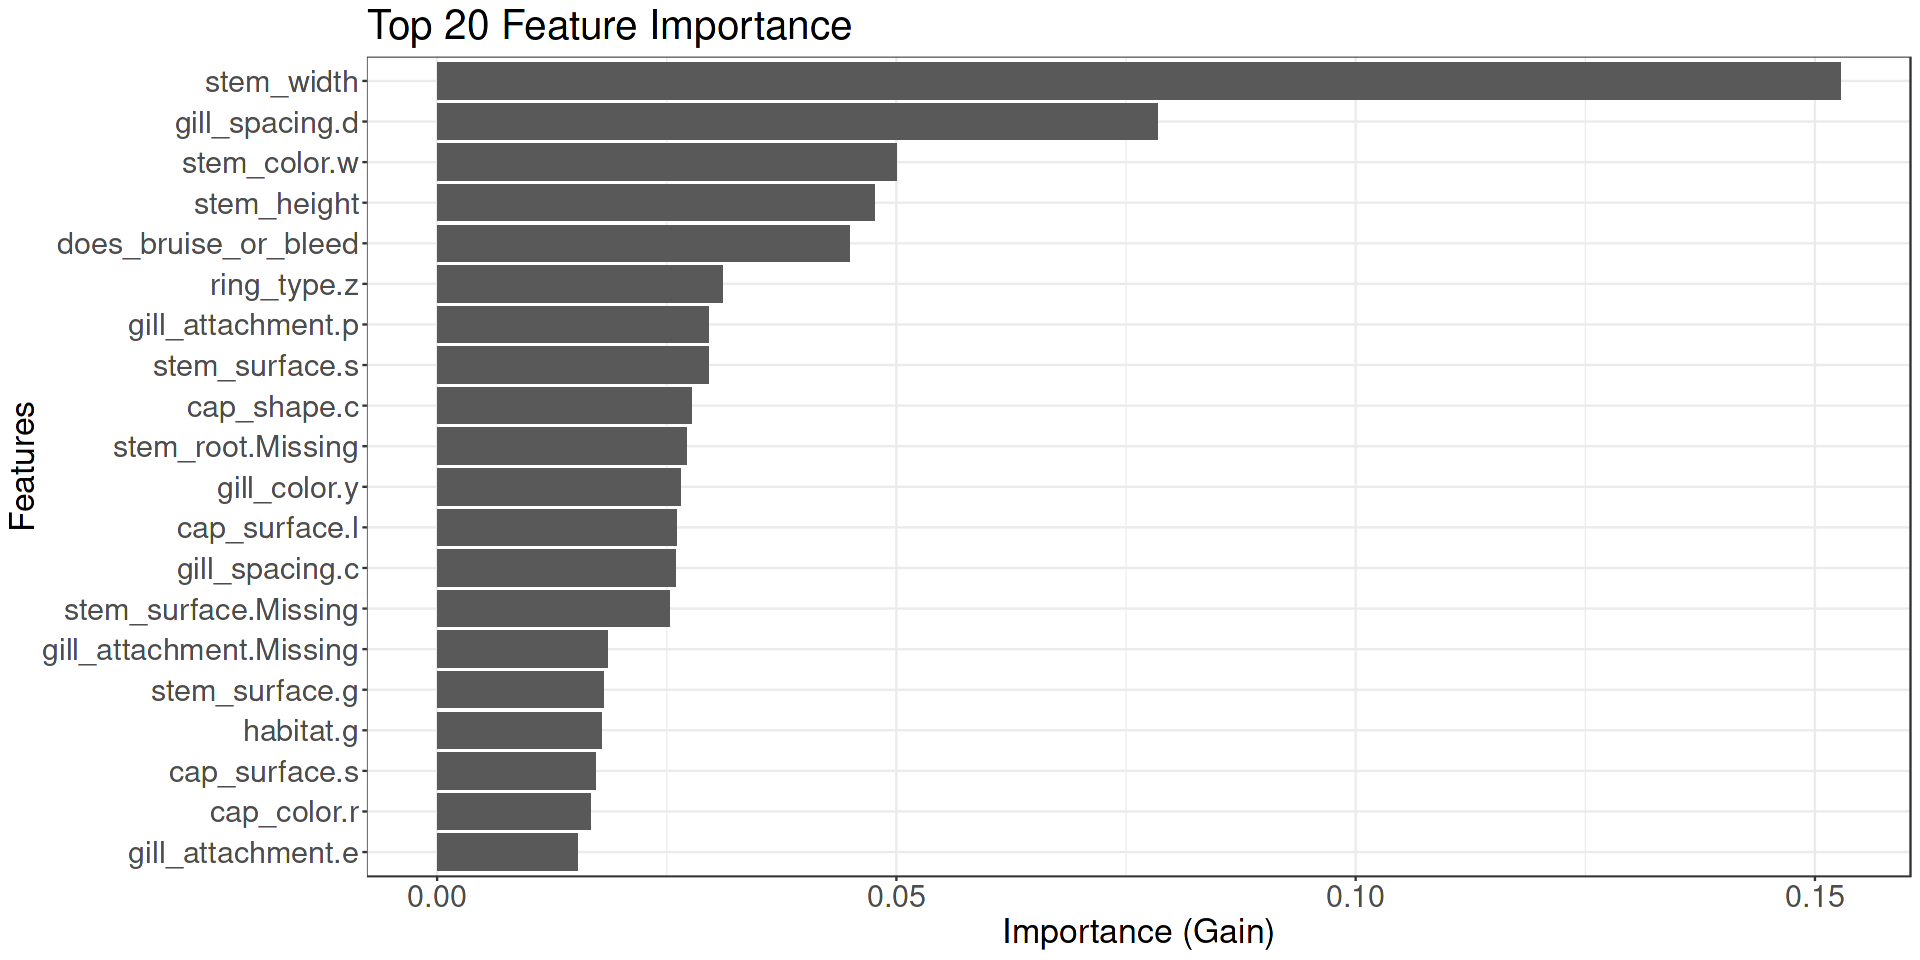

In [ ]:
# Extract feature importance
model <- graph_learner$model$classif.lightgbm$model
feature_importance <- lgb.importance(model)
var_imp_dt <- as.data.table(feature_importance)
setorder(var_imp_dt, -Gain)

options(repr.plot.width=16, repr.plot.height=8)
ggplot(head(var_imp_dt, 20), aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Top 20 Feature Importance", x = "Features", y = "Importance (Gain)") +
  my_theme()

In [ ]:
# Print results
cat("Training set performance (MCC):", train_performance, "\n")
cat("Test set performance (MCC):", test_performance, "\n")

Training set performance (MCC): 0.8415078 
Test set performance (MCC): 0.8431445 


# **mlr3 pipeline - New preprocess + Hyperparameter tunning + Benchmark**

In [ ]:
# Define preprocessing pipelines
prep_onehot <- po("yeojohnson") %>>% po("encode", method = "treatment")
prep_impact <- po("yeojohnson") %>>% po("encodeimpact")

In [ ]:
# Define learners
learner_lgb <- lrn("classif.lightgbm")
learner_glmnet <- lrn("classif.cv_glmnet", alpha = to_tune(0, 1))

# Define expanded search space for LightGBM tuning
search_space_lgb <- ps(
  num_iterations = p_int(lower = 300, upper = 2000),
  max_depth = p_int(lower = 3, upper = 8),
  learning_rate = p_dbl(lower = 0.01, upper = 0.1, logscale = TRUE),
  feature_fraction = p_dbl(lower = 0.5, upper = 1),
  min_child_samples = p_int(lower = 10, upper = 1000)
)

In [ ]:
# Create full pipelines
pipeline_lgb_onehot <- prep_onehot %>>% po(learner_lgb)
pipeline_lgb_impact <- prep_impact %>>% po(learner_lgb)
pipeline_glmnet_onehot <- prep_onehot %>>% po(learner_glmnet)
pipeline_glmnet_impact <- prep_impact %>>% po(learner_glmnet)

# Create graph learners
graph_lgb_onehot <- GraphLearner$new(pipeline_lgb_onehot)
graph_lgb_impact <- GraphLearner$new(pipeline_lgb_impact)
graph_glmnet_onehot <- GraphLearner$new(pipeline_glmnet_onehot)
graph_glmnet_impact <- GraphLearner$new(pipeline_glmnet_impact)

In [ ]:
# Set up tuning for LightGBM learners
at_lgb_onehot <- AutoTuner$new(
  learner = graph_lgb_onehot,
  resampling = rsmp("cv", folds = 3),
  measure = msr("classif.mcc"),
  search_space = search_space_lgb,
  terminator = trm("evals", n_evals = 50),
  tuner = tnr("random_search")
)

at_lgb_impact <- AutoTuner$new(
  learner = graph_lgb_impact,
  resampling = rsmp("cv", folds = 3),
  measure = msr("classif.mcc"),
  search_space = search_space_lgb,
  terminator = trm("evals", n_evals = 50),
  tuner = tnr("random_search")
)

# Set up tuning for Elastic Net learners
at_glmnet_onehot <- AutoTuner$new(
  learner = graph_glmnet_onehot,
  resampling = rsmp("cv", folds = 3),
  measure = msr("classif.mcc"),
  terminator = trm("evals", n_evals = 20),
  tuner = tnr("random_search")
)

at_glmnet_impact <- AutoTuner$new(
  learner = graph_glmnet_impact,
  resampling = rsmp("cv", folds = 3),
  measure = msr("classif.mcc"),
  terminator = trm("evals", n_evals = 20),
  tuner = tnr("random_search")
)


In [ ]:
# Create benchmark design
design <- benchmark_grid(
  tasks = task,
  learners = list(at_lgb_onehot, at_lgb_impact, at_glmnet_onehot, at_glmnet_impact),
  resamplings = rsmp("cv", folds = 5)
)

# Set up parallelization
plan("multisession", workers = parallel::detectCores())

In [ ]:
with_progress({
  bmr <- benchmark(design)
})

INFO  [02:33:24.714] [mlr3] Running benchmark with 20 resampling iterations


ERROR: Error in unserialize(node$con): MultisessionFuture (future_mapply-4) failed to receive message results from cluster RichSOCKnode #4 (PID 2338 on localhost ‘localhost’). The reason reported was ‘error reading from connection’. Post-mortem diagnostic: A process with this PID exists, which suggests that the localhost worker is still alive. Detected a non-exportable reference (‘externalptr’) in one of the globals (‘...future.elements_ii’ of class ‘list’) used in the future expression. The total size of the 5 globals exported is 110.99 MiB. The three largest globals are ‘...future.elements_ii’ (110.97 MiB of class ‘list’), ‘...future.FUN’ (21.67 KiB of class ‘function’) and ‘MoreArgs’ (726 bytes of class ‘list’)


In [ ]:
1+1

[1] 2